In [18]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sp

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [19]:
filename_mouse_embryo = 'E9.5_E1S1.MOSTA.h5ad'
filename_mouse_brain = 'Mouse_brain_cell_bin.h5ad'

K_best_features = [10, 20, 50, 100, 200, 500, 1000, 2000]

In [20]:
def read_file(filename):
    adata = sc.read_h5ad(filename)

    return adata

In [21]:
def preprocess_file(adata):
    #get rid of cells with fewer than 200 genes
    sc.pp.filter_cells(adata, min_genes=200)
    #get rid of genes that are found in fewer than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)
    #get rid of cells whose annotation is unknown
    adata = adata[~adata.obs.annotation.isin(['Unknown'])]
    #data normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    return adata

In [22]:
def select_best_features(adata, k_best_value):
    feature_selector = SelectKBest(k = k_best_value)
    y = adata.obs.annotation
    adata.feature_selected = np.zeros((len(adata.obs.annotation),2))
    adata.feature_selected[:,0]= adata.obsm['spatial'][:,0]
    adata.feature_selected[:,1]= adata.obsm['spatial'][:,1]
    
    feature_selected = feature_selector.fit_transform(adata.X,y)
    adata.feature_selected = np.hstack((adata.feature_selected, feature_selected.toarray() ))
    scaler = StandardScaler()
    adata.feature_selected = scaler.fit_transform(adata.feature_selected,y)

    return adata 

In [23]:
adata = read_file(filename_mouse_embryo)
adata = preprocess_file(adata)
adata


/home/aleks/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 5870 × 23014
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [25]:
adata.obsm['spatial'][:,0].shape
adata.shape

(5870, 23014)

In [26]:
select_best_features(adata, 100)
adata.feature_selected.shape

(5870, 102)

In [9]:
adata.feature_selected[0,:]

array([-0.70276923,  1.76447435,  1.97078833,  1.71854781,  2.05819507,
        3.28202081, -0.51237766, -0.41095217, -0.38840985, -0.31718047,
       -0.38824872, -0.36197326])

In [27]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(adata.feature_selected, adata.obs.annotation)
skf



StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [28]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()


In [29]:
from sklearn.model_selection import cross_val_predict

cv = cross_val_predict(sgd, adata.feature_selected, adata.obs.annotation, cv=10)


/home/aleks/.local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/aleks/.local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


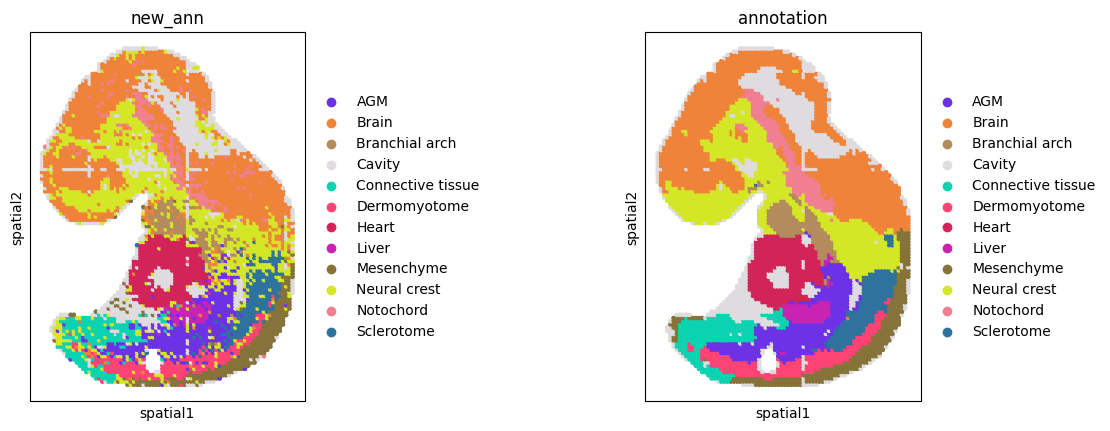

In [62]:
adata.obs['new_ann'] =cv;
adata.uns['new_ann_colors']=adata.uns['annotation_colors']
sp.pl.spatial_scatter(adata,shape=None, color=["new_ann","annotation"])

In [37]:
adata.obs['new_ann']
cv

array(['Mesenchyme', 'Neural crest', 'Mesenchyme', ..., 'Cavity',
       'Cavity', 'Cavity'], dtype='<U17')

SyntaxError: invalid syntax (145349034.py, line 4)

In [ ]:
adata.obs.annotation.shape

In [ ]:
adata.obs.annotation.unique

In [ ]:
adata.obsm